In [1]:
% setup environment
% set path to equilibrium solver
txt=pwd; n=length(txt); rootpath=txt;
last_slash_pos = rindex(rootpath, "/");
rootpath=rootpath(1:last_slash_pos);
JEQUILIBpath=[rootpath,'/JEQUILIB'];
addpath(JEQUILIBpath);
% clear data and number format
clear; format short e
% turn off warnings
warning off
%graphics_toolkit ("notebook"); 
graphics_toolkit ("plotly"); 
%graphics_toolkit("gnuplot")

In [2]:
% define equilibrium problem

FeT=1e-5; PT=1e-5; NaT=3*PT; ClT=3*FeT; pH=2:0.5:12; pe=20.75-pH; T=25; HFOsi=1e-30; HFOwi=1e-30; ASFw=0.2; ASFs=0.2;

In [3]:
function [Fep3,FeLOHR3s,HfowHPO4m3,MASSERR]=FeHPO4tableau(pH,pe,T,flag0,flag1,flag2,flag3,flag4,flag5)

% input tableau.  change this part % ----------------------------------------------

Tableau=[...
{'H+'} {'e-'} {'Fe+3'}  {'PO4-3'}   {'Cl-'}  {'Na+'}  {'Hfos-'}  {'Hfow-'}  {'logK'}                    {'phase'}    {'species'} 
1       0        0      0           0          0       0            0     0                           0          {'H+'}
0       1        0      0           0          0       0            0      0                           0          {'e-'}
0       0        1      0           0          0       0            0     0                           0          {'Fe+3'}
0       0        0      1           0          0       0            0     0                           0          {'PO4-3'}
0       0        0      0           1          0       0            0     0                           0          {'Cl-'}
0       0        0      0           0          1       0            0     0                           0          {'Na+'}
0       0        0      0           0          0       1            0     0                           0          {'Hfos-'}
0       0        0      0           0          0       0            1     0                           0          {'Hfow-'}%%It was like: Hfos+ ; should be Hfow- for that, was the big PHREEQC error
% Kw
-1      0        0      0           0          0       0            0   -14                           0          {'OH-'}
% hydroloysis/redox products
0       1        1      0           0          0       0            0     13.92                       0          {'Fe+2'}
-1      0        1      0           0          0       0            0     -2.19                       0          {'Fe(OH)+2'}
-2      0        1      0           0          0       0            0     -5.67                       0          {'Fe(OH)2+'}
-3      0        1      0           0          0       0            0     -12.56                      0          {'Fe(OH)3'}
-4      0        1      0           0          0       0            0     -21.6                       0          {'Fe(OH)4-'}
-2      0        2      0           0          0       0            0     -2.95                       0          {'Fe2(OH)2+4'}
-4      0        3      0           0          0       0            0     -6.3                        0          {'Fe3(OH)4+5'}
-1      1        1      0           0          0       0            0     -3.52                       0          {'Fe(OH)+'}
-2      1        1      0           0          0       0            0     -7.55                       0          {'Fe(OH)2'}
-3      1        1      0           0          0       0            0     -17.98                      0          {'Fe(OH)3-'}
%phosphoric acid 
1       0        0      1           0        0         0            0     12.346                      0          {'HPO4-2'}
2       0        0      1           0        0         0            0     19.553                      0          {'H2PO4-'}
3       0        0      1           0        0         0            0     21.721                      0          {'H3PO4'}
% Fe-P soluble complexes
1        0       1      1           0        0         0            0     17.776                      0          {'FeHPO4+'}
2        0       1      1           0        0         0            0     24.983                      0          {'FeH2PO4+2'}
1        1       1      1           0        0         0            0     28.966                      0          {'FeHPO4'}
2        1       1      1           0        0         0            0     35.273                      0          {'FeH2PO4+'}
% HFO  SCM reactions
1        0       0      0           0        0         1            0     8.93                        0          {'HfosH'}
2        0       0      0           0        0         1            0     16.22                       0          {'HfosH2+'}
1        0       0      0           0        0         0            1     8.93                        0          {'HfowH'}
2        0       0      0           0        0         0            1     16.22                       0          {'HfowH2+'}
0        0       0      1           0        0         0            1     26.65                       0          {'HfowPO4-4'}
1        0       0      1           0        0         0            1     34.32                       0          {'HfowHPO4-3'}
2        0       0      1           0        0         0            1     40.32                       0          {'HfowH2PO4-2'}
0        0       0      1           0        0         1            0     26.65                       0          {'HfosPO4-4'}
1        0       0      1           0        0         1            0     34.32                       0          {'HfosHPO4-3'}
2        0       0      1           0        0         1            0     40.22                       0          {'HfosH2PO4-2'}
%solids
-3      0        1      0           0        0         0            0     -4.891                      1          {'Fe(OH)3s'} %HFO
0       0        1      1           0        0         0            0     23.2                        1          {'Fe(PO4)s'} % strengite
0       3        3      2           0        0        0            0      75.06                       1          {'Fe3(PO4)2s'} %vivianite
];


% end of tableau.  ------------------ % ----------------------------------------------

if flag0==0 % solve with tableau (using other flags for options)

[KSOLID,ASOLID,SOLIDNAMES,KSOLUTION,ASOLUTION,SOLUTIONNAMES]=processtableau(Tableau(2:end,1:end),pH,pe);
    [SPECIESCONCS,SPECIATIONNAMES,masserr,X]=returnspeciationRE(KSOLID,ASOLID,SOLIDNAMES,KSOLUTION,ASOLUTION,SOLUTIONNAMES,...
    T,flag1,flag2,flag3,flag4,flag5);
    for k=1:size(SPECIESCONCS,1)
          txt=[SPECIATIONNAMES(k,:),'=SPECIESCONCS(k);'];
          eval(txt)
    end
    
    %[MASSERR,IDX]=max((MASSERR)); % oops. this would ignore negative errors
    %MASSERR=max(100*((MASSERR)./T)); % relative does not make sense when some components are so tiny (like HFOinitial conc)
    [MASSERR,INDX]=max(abs(masserr)); MASSERR=MASSERR*sign(masserr(INDX));
end

end 

In [4]:
% MODEL USING TABLEAU (different gradients or log versus linear variables)
%graphics_toolkit("notebook")
%model with just inorganic speciation
%geochemical model
% input the constants and solution chemistry
flag0=0; %choose solver. 0 for tableau and 1 for phreeqc-based solver
flag1=2; %flag1 for concentration based search vector (1) or for log based search vector (2).
flag2=1; %flag2 for numerical derivatives (2) or analtyical derivatives (1)
flag3=0; % flag3 1 for show warnings. 0 no warnings
flag4=1; %if=1 solve tableau one line at a time to get a good initial guess (no solids). really challenging probs only
flag5=0; %if=1 use stored initial guess for including solids

TOTALS=[FeT; PT; ClT; NaT; HFOsi; HFOwi]';
TOTALS(TOTALS==0)=1e-16; % get rid of zero values, b/c div by zero error

for i=1:length(pH)
if i>1; flag5=1; end
[Fep3(i),HFO(i),HfowHPO4m(i),MASSERR(i)]=FeHPO4tableau(pH(i),pe(i),TOTALS',flag0,flag1,flag2,flag3,flag4,flag5); 
if HFO(i)>0; % should make loop until HFO value converges, but from previous tests it converges fast.  one step was how I did the 2008 WER paper
    HFOs=ASFs*HFO(i); HFOw=ASFw*HFO(i); 
    TOTALS=[FeT; PT; ClT; NaT; HFOs; HFOw]';
    flag5=1;
    [Fep3(i),HFO(i),HfowHPO4m3(i),MASSERR(i)]=FeHPO4tableau(pH(i),pe(i),TOTALS',flag0,flag1,flag2,flag3,flag4,flag5);
end
end

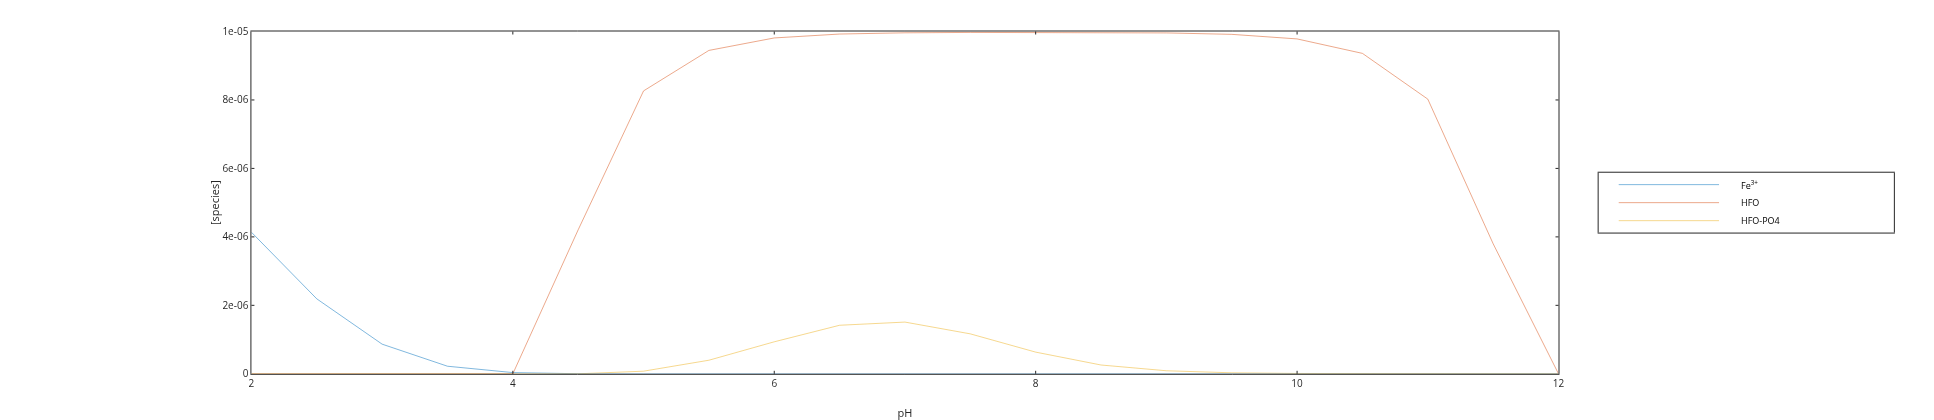

In [5]:
plot(pH,Fep3,pH,HFO,pH,HfowHPO4m)
xlabel('pH'); ylabel('[species]'); legend('Fe^{3+}','HFO','HFO-PO4','location','eastoutside')

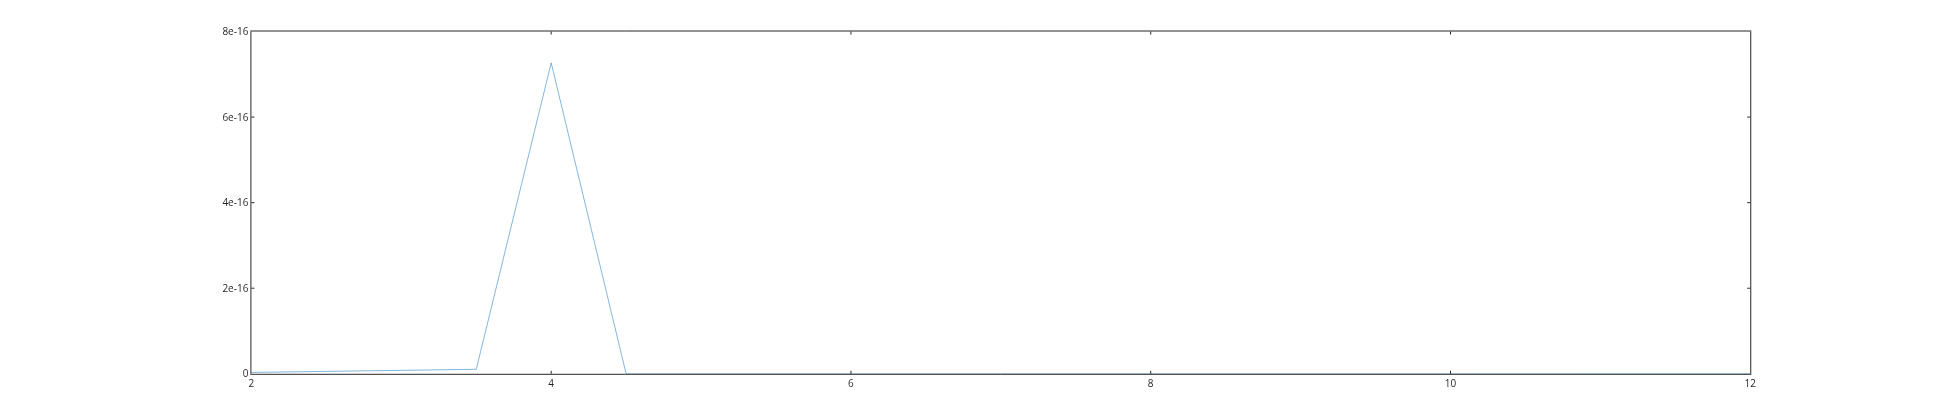

In [6]:
plot(pH,MASSERR)